In [166]:
%reload_ext autoreload
%autoreload 2

In [167]:
def download_file(url, path, download_path):
    """Download the dataset"""
    if not os.path.isdir(path):
        os.makedirs(path)
    urllib.request.urlretrieve(url, download_path)
    if (os.path.isfile(download_path)):
        print(f'Download path: {download_path}')

In [168]:
import os
import zipfile
import pandas as pd
import numpy as np
from six.moves import urllib

DOWNLOAD_ROOT = "http://www.sportstoto.com.my/"
LOTTO_PATH = os.path.join(os.getcwd(), "test_data", "lotto")

_4D_URL = DOWNLOAD_ROOT + "upload/4D.zip"
_4D_ZIP = os.path.join(LOTTO_PATH, "4D.zip")
download_file(_4D_URL, LOTTO_PATH, _4D_ZIP)

Download path: /content/test_data/lotto/4D.zip


In [169]:
downloaded_file = _4D_ZIP
df = pd.read_csv(downloaded_file, header=0, sep=',', quotechar='"', dtype=str)
df['DrawDate']= pd.to_datetime(df['DrawDate'], format='%Y%m%d')
df.tail(2)

,DrawNo,DrawDate,1stPrizeNo,2ndPrizeNo,3rdPrizeNo,SpecialNo1,SpecialNo2,SpecialNo3,SpecialNo4,SpecialNo5,SpecialNo6,SpecialNo7,SpecialNo8,SpecialNo9,SpecialNo10,ConsolationNo1,ConsolationNo2,ConsolationNo3,ConsolationNo4,ConsolationNo5,ConsolationNo6,ConsolationNo7,ConsolationNo8,ConsolationNo9,ConsolationNo10
4888,538821,2021-12-12,0436,5107,9944,2291,8945,4647,7228,5580,9122,7006,1341,0214,8606,2032,1406,1573,4359,1270,6801,4196,7765,1499,6901
4889,538921,2021-12-15,1138,0886,2059,1298,1844,1327,9516,5899,1433,1912,0303,4733,8682,3493,7669,8406,5734,7835,5327,4605,8416,7601,0333


In [170]:
def apply_checksum(row):
    """Calculate unique checksum for each date"""
    cksum = calc_checksum(row["1stPrizeNo"])
    cksum = cksum + calc_checksum(row["2ndPrizeNo"])
    cksum = cksum + calc_checksum(row["3rdPrizeNo"])
    for idx in range(10):
        col = "SpecialNo" + str(idx + 1)
        cksum = cksum + calc_checksum(row[col])
    for idx in range(10):
        col = "ConsolationNo" + str(idx + 1)
        cksum = cksum + calc_checksum(row[col])
    return cksum

def calc_checksum(no):
    return ( (int(no[0]) * 1) + (int(no[1]) * 100) + (int(no[2]) * 10) + (int(no[3]) * 1000) ) 
    
    
df["CheckSum"] = df.apply(apply_checksum, axis=1)
df.tail(10)

,DrawNo,DrawDate,1stPrizeNo,2ndPrizeNo,3rdPrizeNo,SpecialNo1,SpecialNo2,SpecialNo3,SpecialNo4,SpecialNo5,SpecialNo6,SpecialNo7,SpecialNo8,SpecialNo9,SpecialNo10,ConsolationNo1,ConsolationNo2,ConsolationNo3,ConsolationNo4,ConsolationNo5,ConsolationNo6,ConsolationNo7,ConsolationNo8,ConsolationNo9,ConsolationNo10,CheckSum
4880,538021,2021-11-28,2617,5522,4776,0297,6088,0337,7253,4374,5167,3930,1407,1118,1323,8912,5418,9738,2516,0833,6079,3447,6405,0700,0555,132768
4881,538121,2021-11-30,3627,3096,7803,7570,8777,2863,8540,7048,1657,4994,3587,0065,6171,4839,3518,6125,9418,6703,6724,6852,7923,8295,2316,123516
4882,538221,2021-12-01,7532,6792,6505,9696,6481,9223,1385,4187,3612,7372,5050,6716,6403,3792,4163,3504,4133,6545,5261,6284,9646,8465,3622,89416
4883,538321,2021-12-04,2607,3836,8540,4848,8080,8018,6807,6238,2486,0771,0504,2154,9826,6737,6982,3010,8217,5414,7137,0145,2421,2362,4997,118131
4884,538421,2021-12-05,1635,7492,6019,5295,2741,0482,7006,8132,8463,9402,3078,0863,7792,2474,7333,9239,7467,7016,5916,2106,8584,1789,4330,113665
4885,538521,2021-12-07,4639,6922,6676,5271,1713,0473,0227,2671,2250,7284,7747,3505,1156,9734,0955,9792,6117,6947,9976,5670,1412,7253,9914,107315
4886,538621,2021-12-08,8128,1211,0287,7649,4181,5522,9241,8835,7188,5081,2301,3470,7892,6198,9287,6095,5490,9125,6038,9326,1350,5679,4781,103386
4887,538721,2021-12-11,2899,2093,5562,5768,7794,8404,3020,9378,0870,1049,1329,7613,3170,2902,3170,1083,7939,4531,8300,8089,1379,4365,5909,116606
4888,538821,2021-12-12,0436,5107,9944,2291,8945,4647,7228,5580,9122,7006,1341,0214,8606,2032,1406,1573,4359,1270,6801,4196,7765,1499,6901,109268
4889,538921,2021-12-15,1138,0886,2059,1298,1844,1327,9516,5899,1433,1912,0303,4733,8682,3493,7669,8406,5734,7835,5327,4605,8416,7601,0333,131418


## Train Test Data


In [184]:
print(len(df))
print(len(df[0:4800]))
df = df[0:4800].copy()
df.tail(10)

4890
4800


,DrawNo,DrawDate,1stPrizeNo,2ndPrizeNo,3rdPrizeNo,SpecialNo1,SpecialNo2,SpecialNo3,SpecialNo4,SpecialNo5,SpecialNo6,SpecialNo7,SpecialNo8,SpecialNo9,SpecialNo10,ConsolationNo1,ConsolationNo2,ConsolationNo3,ConsolationNo4,ConsolationNo5,ConsolationNo6,ConsolationNo7,ConsolationNo8,ConsolationNo9,ConsolationNo10,CheckSum
4790,523821,2021-02-09,4725,0100,6483,1302,1162,2825,1965,0717,5875,6121,5734,6283,9977,4214,6224,6235,7281,0226,9752,0045,3942,8230,7329,97756
4791,523921,2021-02-10,4959,9923,0350,2784,4053,0482,4883,1636,5651,8562,6486,5919,4795,1347,7524,5522,3169,4350,8415,1427,1805,3086,2079,119187
4792,524021,2021-02-13,2502,3079,7311,9708,1024,5968,0636,3488,0239,1495,8951,2153,2313,9531,9830,8647,9425,8651,8035,4687,0305,8881,5055,114921
4793,524121,2021-02-14,3389,7888,5337,4784,0442,1053,5220,6786,9906,3064,7564,0189,9443,6646,5336,8422,2457,6757,8656,7753,2647,3599,8897,137224
4794,524221,2021-02-16,9619,7545,4152,9883,1701,5255,7683,6966,7443,7151,8329,3885,3688,6666,0018,1070,9957,3998,0109,0489,8125,6250,5098,131074
4795,524321,2021-02-17,1298,9653,8610,9684,5903,2461,8080,0348,9932,8964,7603,5839,8182,6399,3834,9877,9239,2627,8782,9284,7138,7453,8248,120477
4796,524421,2021-02-20,5356,7059,2165,7488,7745,5337,3631,7881,4289,4403,9198,5825,5025,0043,8091,1935,9304,3789,1500,5671,5537,5264,9494,120036
4797,524521,2021-02-21,1369,5633,3402,2161,4221,9795,0929,3341,4241,1452,0961,3054,0892,8110,9339,9477,0928,0679,1286,3663,4524,9897,6590,105934
4798,524621,2021-02-24,0971,9898,5582,8581,0144,4174,9336,8355,4922,2089,5837,3905,5128,9305,1721,1320,3793,2317,4832,1526,9213,2010,6865,105830
4799,524721,2021-02-27,5597,4366,9967,1888,7472,8613,3278,5525,6212,7064,2782,7204,4795,3622,4739,4462,1763,6017,0651,9154,0259,3043,1782,116249


In [185]:
LOOK_AHEAD = 15
AVERAGE_COUNT = 15

df_test = df[-LOOK_AHEAD:].copy()
df_train = df[0:-LOOK_AHEAD].copy()

DT_TEST = df_test.iloc[0]['DrawDate']

#df_train = df[df['DrawDate'] < DT_TEST].copy()
#df_test = df[df['DrawDate'] >= DT_TEST].copy()

print(DT_TEST)
print(len(df_train), df_train.tail(LOOK_AHEAD))
print(len(df_test), df_test.tail(LOOK_AHEAD))

2021-01-31 00:00:00
4785       DrawNo   DrawDate 1stPrizeNo  ... ConsolationNo9 ConsolationNo10 CheckSum
4770  521820 2020-12-30       0659  ...           4762            5879   119303
4771  521921 2021-01-02       5220  ...           8005            6460   105535
4772  522021 2021-01-03       9192  ...           9979            4126   133684
4773  522121 2021-01-06       1276  ...           7119            0688   120449
4774  522221 2021-01-09       8762  ...           3802            2505   121660
4775  522321 2021-01-10       3904  ...           5480            9924    97852
4776  522421 2021-01-13       0133  ...           8410            1297   117645
4777  522521 2021-01-16       8992  ...           1811            5501   105881
4778  522621 2021-01-17       1246  ...           9708            2798   124530
4779  522721 2021-01-20       6136  ...           5664            8783   116046
4780  522821 2021-01-23       5708  ...           2907            5149   123429
4781  522921 20

## Time Series Forecast

In [186]:
!pip install -Uq pystan==2.19.1.1
!pip install -Uq prophet

In [187]:
from prophet import Prophet

In [188]:
ts = df_train[["DrawDate","CheckSum"]].copy()
ts.rename(columns={"DrawDate": 'ds', "CheckSum": "y" }, inplace=True)
ts.tail(10)

,ds,y
4775,2021-01-10,97852
4776,2021-01-13,117645
4777,2021-01-16,105881
4778,2021-01-17,124530
4779,2021-01-20,116046
4780,2021-01-23,123429
4781,2021-01-24,86542
4782,2021-01-26,125912
4783,2021-01-27,99182
4784,2021-01-30,94530


In [189]:
m = Prophet(daily_seasonality=False)
m.fit(ts)
future = m.make_future_dataframe(periods=LOOK_AHEAD)
print(len(ts))
print(ts.tail(LOOK_AHEAD))
print(len(future))
print(future.tail(LOOK_AHEAD))

4785
             ds       y
4770 2020-12-30  119303
4771 2021-01-02  105535
4772 2021-01-03  133684
4773 2021-01-06  120449
4774 2021-01-09  121660
4775 2021-01-10   97852
4776 2021-01-13  117645
4777 2021-01-16  105881
4778 2021-01-17  124530
4779 2021-01-20  116046
4780 2021-01-23  123429
4781 2021-01-24   86542
4782 2021-01-26  125912
4783 2021-01-27   99182
4784 2021-01-30   94530
4800
             ds
4785 2021-01-31
4786 2021-02-01
4787 2021-02-02
4788 2021-02-03
4789 2021-02-04
4790 2021-02-05
4791 2021-02-06
4792 2021-02-07
4793 2021-02-08
4794 2021-02-09
4795 2021-02-10
4796 2021-02-11
4797 2021-02-12
4798 2021-02-13
4799 2021-02-14


In [190]:
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(LOOK_AHEAD))

             ds           yhat     yhat_lower     yhat_upper
4785 2021-01-31  116231.772462   99859.968754  134626.445205
4786 2021-02-01  122909.994032  104719.118867  138954.021067
4787 2021-02-02  117040.096397   98737.186796  133017.524631
4788 2021-02-03  115682.693778   98104.432981  132511.043743
4789 2021-02-04  113157.507887   95606.624640  130666.138078
4790 2021-02-05  123127.993928  105363.252588  139643.757238
4791 2021-02-06  114891.403326   96845.851619  133041.593843
4792 2021-02-07  116585.977551   99375.725282  134922.066050
4793 2021-02-08  123240.514595  104423.372416  140436.842310
4794 2021-02-09  117330.920007   99967.335228  134505.291325
4795 2021-02-10  115917.666792   98765.286557  132154.189379
4796 2021-02-11  113320.866894   96109.631357  130753.943296
4797 2021-02-12  123204.901810  105288.937382  142426.346609
4798 2021-02-13  114868.474021   97588.556682  132473.888572
4799 2021-02-14  116451.773606   99463.776514  134608.815300


In [191]:
print(df_test.head(LOOK_AHEAD))

      DrawNo   DrawDate 1stPrizeNo  ... ConsolationNo9 ConsolationNo10 CheckSum
4785  523321 2021-01-31       6286  ...           5342            6190   106047
4786  523421 2021-02-02       3915  ...           4256            3197   117129
4787  523521 2021-02-03       1295  ...           4269            1210   102135
4788  523621 2021-02-06       6314  ...           8742            2092    93170
4789  523721 2021-02-07       2478  ...           5792            9029   119322
4790  523821 2021-02-09       4725  ...           8230            7329    97756
4791  523921 2021-02-10       4959  ...           3086            2079   119187
4792  524021 2021-02-13       2502  ...           8881            5055   114921
4793  524121 2021-02-14       3389  ...           3599            8897   137224
4794  524221 2021-02-16       9619  ...           6250            5098   131074
4795  524321 2021-02-17       1298  ...           7453            8248   120477
4796  524421 2021-02-20       5356  ... 

## Validation

In [192]:
#df_future = forecast[forecast['ds'] >= DT_TEST].copy()
#df_future = forecast.copy()
df_future = forecast[forecast['ds'] >= DT_TEST].copy()
df_future = df_future[:AVERAGE_COUNT]
print(df_future)
mean = int(df_future["yhat"].mean())
print(mean)
#mean = int(df_future.iloc[0]['yhat'])

             ds          trend  ...  multiplicative_terms_upper           yhat
4785 2021-01-31  116367.469738  ...                         0.0  116231.772462
4786 2021-02-01  116367.588262  ...                         0.0  122909.994032
4787 2021-02-02  116367.706787  ...                         0.0  117040.096397
4788 2021-02-03  116367.825311  ...                         0.0  115682.693778
4789 2021-02-04  116367.943836  ...                         0.0  113157.507887
4790 2021-02-05  116368.062361  ...                         0.0  123127.993928
4791 2021-02-06  116368.180885  ...                         0.0  114891.403326
4792 2021-02-07  116368.299410  ...                         0.0  116585.977551
4793 2021-02-08  116368.417934  ...                         0.0  123240.514595
4794 2021-02-09  116368.536459  ...                         0.0  117330.920007
4795 2021-02-10  116368.654984  ...                         0.0  115917.666792
4796 2021-02-11  116368.773508  ...                 

In [193]:
df_train['Target'] = mean
df_train['Diff'] = abs(df_train['CheckSum'] - mean)
min = df_train['Diff'].min()
print(df_train.tail(10))
print(min)  
df_target = df_train[df_train['Diff'] == min].copy()
print(df_target.head(10))

def get_number_list(row):
  l = list()
  l.append(row["1stPrizeNo"])
  l.append(row["2ndPrizeNo"])
  l.append(row["3rdPrizeNo"])

  for idx in range(10):
      col = "SpecialNo" + str(idx + 1)
      l.append(row[col])
  for idx in range(10):
      col = "ConsolationNo" + str(idx + 1)
      l.append(row[col])
      
  return l

def check_result(row, df_check):
  chk_list = get_number_list(df_check.iloc[0])
  test_list = get_number_list(row)
  check =  any(item in chk_list for item in test_list)
  if check:
    print("Test:", test_list)
    #print("Check:", chk_list)
    for n in test_list:
      if n in chk_list:
        print("Matching ", n)
  return check

df_test["Match"] = df_test.apply(check_result, axis=1, df_check=df_target)
print(df_test)

      DrawNo   DrawDate 1stPrizeNo  ... CheckSum  Target   Diff
4775  522321 2021-01-10       3904  ...    97852  117597  19745
4776  522421 2021-01-13       0133  ...   117645  117597     48
4777  522521 2021-01-16       8992  ...   105881  117597  11716
4778  522621 2021-01-17       1246  ...   124530  117597   6933
4779  522721 2021-01-20       6136  ...   116046  117597   1551
4780  522821 2021-01-23       5708  ...   123429  117597   5832
4781  522921 2021-01-24       7695  ...    86542  117597  31055
4782  523021 2021-01-26       4862  ...   125912  117597   8315
4783  523121 2021-01-27       1340  ...    99182  117597  18415
4784  523221 2021-01-30       4423  ...    94530  117597  23067

[10 rows x 28 columns]
0
      DrawNo   DrawDate 1stPrizeNo  ... CheckSum  Target Diff
2503  291107 2007-10-17       8927  ...   117597  117597    0

[1 rows x 28 columns]
Test: ['3915', '9117', '0494', '4366', '0003', '1212', '1216', '5646', '4642', '8695', '4251', '2438', '6367', '3975', '137

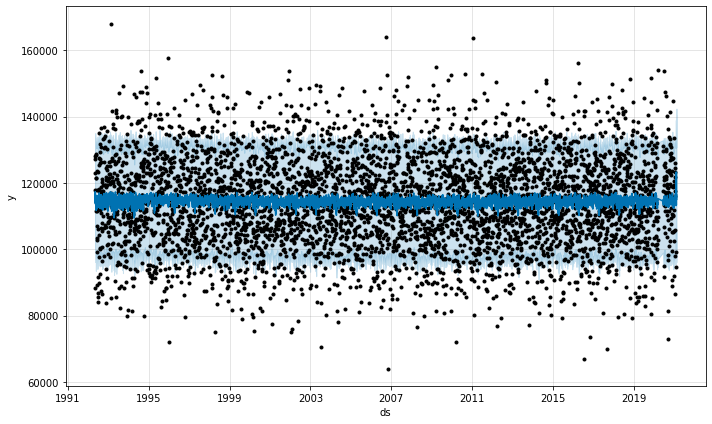

In [194]:
fig1 = m.plot(forecast)

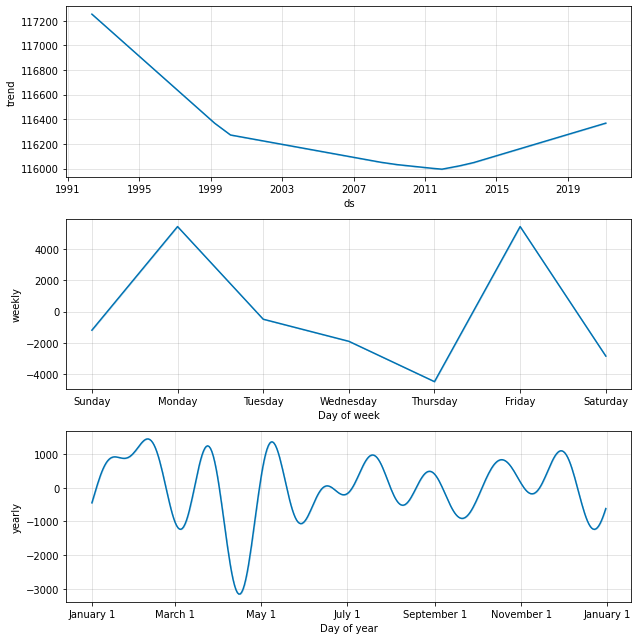

In [195]:
fig2 = m.plot_components(forecast)